# Fraud Detection

This project involves using Self-Organizing Maps to detect possible credit card fraudsters from data extracted from past credit card applications followed by using an ANN classification model trained on the previously learned data to predict the probability that each customer cheated.

### Importing the libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the dataset

In [2]:
dataset = pd.read_csv('Data/Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

### Feature Scaling


In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

### Training the SOM


In [4]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

### Visualizing the results


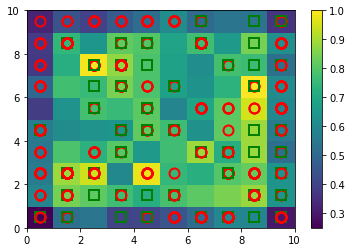

In [5]:
from pylab import pcolor, colorbar, plot, show
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

* The yellow rectangles have the highest Mean Inter-neuron Distance making them outliers and hence contain potential frauds.
* The red circles are the winning nodes.
* The green squares are nodes whose credit card applications have been accepted.

Therefore, nodes in yellow rectangle with both a red circle and a green square are at high risk of having frauds whose applications have been accepted.

### Finding the frauds


In [6]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(1,1)], mappings[(4,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

### IDs of Fraud Clients

In [7]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15796813
15731166
15729771
15721507
15700046
15587443
15774262


### Creating a Matrix of Features

In [8]:
customers = dataset.iloc[:, 1:].values

### Creating a Dependent Variable

In [9]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

### Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Importing TensorFlow

In [11]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Initializing the ANN

In [12]:
ann = tf.keras.models.Sequential()

### Adding the input layer and the first hidden layer

In [13]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

### Adding the output layer

In [14]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Compiling the ANN

In [15]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training the ANN on the Training set

In [16]:
ann.fit(customers, is_fraud, batch_size = 1, epochs = 10)

Epoch 1/10
690/690 [==============================] - 5s 1ms/step - loss: 0.4097 - accuracy: 0.9931
Epoch 2/10
690/690 [==============================] - 1s 1ms/step - loss: 0.2128 - accuracy: 0.9905
Epoch 3/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1434 - accuracy: 0.9867
Epoch 4/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1105 - accuracy: 0.9880
Epoch 5/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0724 - accuracy: 0.9875
Epoch 6/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0611 - accuracy: 0.9904
Epoch 7/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0538 - accuracy: 0.9893
Epoch 8/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0398 - accuracy: 0.9927
Epoch 9/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0429 - accuracy: 0.9893
Epoch 10/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0332 - accuracy: 0.9906

### Predicting test set results

In [17]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

In [18]:
print(y_pred)

[[1.56739070e+07 4.62860680e-06]
 [1.57574340e+07 5.19053174e-06]
 [1.56085950e+07 1.89614584e-05]
 ...
 [1.58127660e+07 1.33823276e-01]
 [1.57311660e+07 1.82387382e-01]
 [1.57968130e+07 1.82387382e-01]]
